In [418]:
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [419]:
signal1 = []
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm1.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm2.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm3.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm4.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm5.mat"))
signal1.append(io.loadmat("../Data/MaTh_MM/Signal1_Mm6.mat"))

In [420]:
data = []
for dat in signal1[:6]:
    data.append(dat["X"])

In [439]:
dataList = []
for index_example in range(100):
    frame = pd.DataFrame()
    for index_feature in range(6):
        if len(frame.index) > 0 :
            frame[index_feature] = pd.DataFrame(data[index_feature][index_example])
        else:
            frame = pd.DataFrame(data[index_feature][index_example])
    dataList.append(frame)
    

In [422]:
data_U = []    
for dat in signal1[:6]:
    data_U.append(dat["U"])
dataList_U = []
for index_example in range(100):
    frame = pd.DataFrame()
    for index_feature in range(6):
        if len(frame.index) > 0 :
            frame[index_feature] = pd.DataFrame(data_U[index_feature][index_example])
        else:
            frame = pd.DataFrame(data_U[index_feature][index_example])
    dataList_U.append(frame)

<AxesSubplot:>

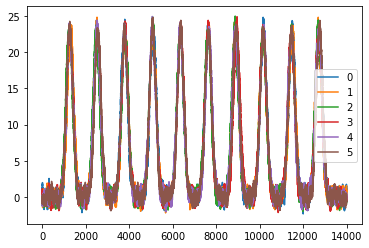

In [440]:
dataList[0].plot()

2 Signale, 100 Beispiele, 6 Merkmale (Kanäle). Zeitachse: -23s ... 5s, Abtastrate: 500 Werte pro Sekunde.

In [424]:
dataList_not_sampled = dataList.copy()
for i,df in enumerate(dataList):
    df.index = pd.to_datetime(
        np.arange(0, len(df.index)*2, 2).tolist(),
        unit="ms")
    dataList[i] = df.resample("100ms").mean()

In [425]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """Turns a timeseries into a supervised series
    which can be used with supvervised learning methods

    Args:
        data ([type]): Usually a dataframe
        n_in (int, optional): Lag of the input. Defaults to 1.
        n_out (int, optional): how many Timesteps forecast into the future. Defaults to 1.
        dropnan (bool, optional): Drop rows that contain NaN values. Defaults to True.

    Returns:
        Dataframe: Dataframe with lag and output
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(data.columns[j], i))
                  for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(data.columns[j]))
                      for j in range(n_vars)]
        else:
            names += [('{}(t+{})'.format(data.columns[j], i))
                      for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [426]:
def getXandY(df_temp):
    dataframe = pd.DataFrame(df_temp)
    
    dataframe.index = df_temp.index

    dataframe_shifted = series_to_supervised(dataframe,Timesteps_past-1,Timesteps_future+1)

    X_dataframe = dataframe_shifted[dataframe_shifted.columns.drop(list(dataframe_shifted.filter(regex='\+')))]
    y_dataframe = dataframe_shifted.filter(regex='\(t\+')

    X_dataframe = X_dataframe.to_numpy()
    y_dataframe = y_dataframe.to_numpy()


    X_dataframe = X_dataframe.reshape(X_dataframe.shape[0], Timesteps_past, Features) # (samples, time steps, features).

    y_dataframe = y_dataframe.reshape(y_dataframe.shape[0], Timesteps_future, Features) # (samples, time steps, features).

    #print(X_dataframe.shape,y_dataframe.shape)

    return X_dataframe, y_dataframe, dataframe_shifted

Second way


In [427]:
Timesteps_past = 50
Features = 6
Timesteps_future = 50

In [428]:
X_train = []
y_train = []
for df in dataList[:95]:
    #df = df[:-50]
    X, y, train_shifted = getXandY(df)
    for i in range(len(X)):
        X_train.append(X[i])
        y_train.append(y[i])
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
print(X_train.shape, y_train.shape)

(17290, 50, 6) (17290, 50, 6)


In [429]:
X_test = []
y_test= []
for df in dataList[95:]:
    X, y, train_shifted = getXandY(df)
    for i in range(len(X)):
        X_test.append(X[i])
        y_test.append(y[i])
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
print(X_test.shape, y_test.shape)

(910, 50, 6) (910, 50, 6)


In [430]:
X_valid = []
y_valid= []
for df in dataList[95:]:
    df = df[-100:]
    X, y, train_shifted = getXandY(df)
    X_valid.append(X[0])
    y_valid.append(y[0])
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid)
print(X_valid.shape, y_valid.shape)

(5, 50, 6) (5, 50, 6)


In [431]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(100, 6)))
model.add(LSTM(10, activation='relu'))
model.add(Dense(units=50*6))
model.add(Reshape((50, 6)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 100, 100)          42800     
_________________________________________________________________
lstm_63 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_32 (Dense)             (None, 300)               3300      
_________________________________________________________________
reshape_32 (Reshape)         (None, 50, 6)             0         
Total params: 50,540
Trainable params: 50,540
Non-trainable params: 0
_________________________________________________________________


In [432]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [433]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()
X_valid_original = X_valid.copy()
y_train_original = y_train.copy()
y_test_original = y_test.copy()
y_valid_original = y_valid.copy()

In [434]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# Scale X
scaler_X= RobustScaler()
X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test= scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_valid = scaler_X.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
# Scale y
scaler_y= RobustScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_test = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)
y_valid = scaler_y.transform(y_valid.reshape(-1, y_valid.shape[-1])).reshape(y_valid.shape)


In [435]:
model.fit(X_train,y_train,epochs=2,verbose=1)

Epoch 1/2
541/541 [==============================] - 60s 92ms/step - loss: 0.2193
Epoch 2/2
541/541 [==============================] - 45s 84ms/step - loss: 0.0188


Settings
!! Data got resampled to 100ms steps
   Timesteps_ past: 50
   Timesteps_ future: 50
-> Evaluation:
   Mean squared error: 0.02121851922058873
   Mean absolute error: 0.10755383445190471
-> Evaluation after Rescaling:
   Mean squared error: 3.4237686388684185
   Mean absolute error: 1.3663445841565798


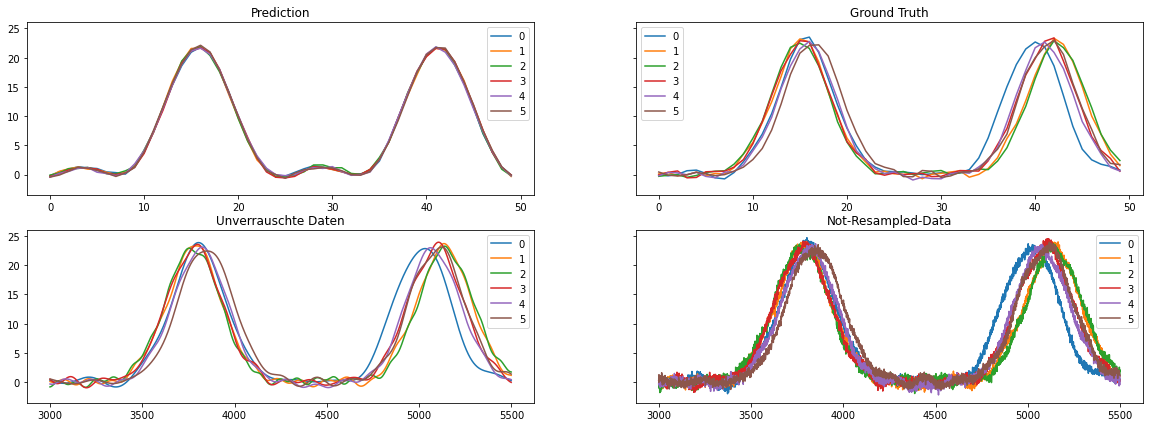

In [445]:
predictions = model.predict(X_test)
predictions_rescaled  = scaler_y.inverse_transform(predictions.reshape(-1, predictions.shape[-1])).reshape(predictions.shape)
from sklearn.metrics import mean_squared_error, mean_absolute_error
i = 1

print("Settings")
print("!! Data got resampled to 100ms steps")
print("   Timesteps_ past: {}".format(Timesteps_past))
print("   Timesteps_ future: {}".format(Timesteps_future))
print("-> Evaluation:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions[i], y_test[i])))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions[i], y_test[i])))
print("-> Evaluation after Rescaling:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions_rescaled[i], y_test_original[i])))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions_rescaled[i], y_test_original[i])))
for i in range(1):
    f, ((ax1, ax2),( ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=(20,7))
    pd.DataFrame(predictions_rescaled[10]).plot(ax = ax1)
    pd.DataFrame(y_test_original[10]).plot(ax=ax2)
    pd.DataFrame(dataList_U[95][3000:5500]).plot(ax=ax3)
    pd.DataFrame(dataList[95][3000:5500]).plot(ax=ax4)
    ax1.title.set_text('Prediction')
    ax2.title.set_text('Ground Truth')
    ax3.title.set_text('Unverrauschte Daten')
    ax4.title.set_text('Not-Resampled-Data')

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f88f12ea670>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Settings
!! Data got resampled to 100ms steps
   Timesteps_ past: 50
   Timesteps_ future: 50
Evaluation:
   Mean squared error: 0.18049264521338534
   Mean absolute error: 0.20647556509143786
Evaluation after Rescaling:
   Mean squared error: 29.129144729120558
   Mean absolute error: 2.6231615370807617


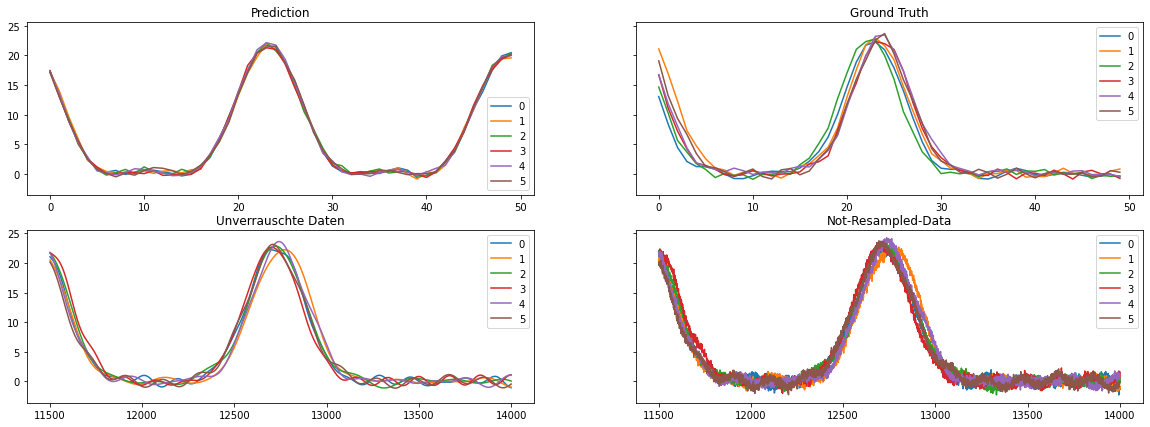

In [449]:
predictions = model.predict(X_valid)
predictions_rescaled  = scaler_y.inverse_transform(predictions.reshape(-1, predictions.shape[-1])).reshape(predictions.shape)
from sklearn.metrics import mean_squared_error, mean_absolute_error
i = 3
print("Settings")
print("!! Data got resampled to 100ms steps")
print("   Timesteps_ past: {}".format(Timesteps_past))
print("   Timesteps_ future: {}".format(Timesteps_future))
print("Evaluation:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions[i], y_valid[i])))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions[i], y_valid[i])))
print("Evaluation after Rescaling:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions_rescaled[i], y_valid_original[i])))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions_rescaled[i], y_valid_original[i])))
for i in range(1):
    f, ((ax1, ax2),( ax3,ax4)) = plt.subplots(2, 2, sharey=True,figsize=(20,7))
    pd.DataFrame(predictions_rescaled[i]).plot(ax = ax1)
    pd.DataFrame(y_valid_original[i]).plot(ax=ax2)
    pd.DataFrame(dataList_U[96+i][-2500:]).plot(ax=ax3)
    pd.DataFrame(dataList[96+i][-2500:]).plot(ax=ax4)
    ax1.title.set_text('Prediction')
    ax2.title.set_text('Ground Truth')
    ax3.title.set_text('Unverrauschte Daten')
    ax4.title.set_text('Not-Resampled-Data')